### Comparing Models and Vectorization Strategies for Text Classification

This try-it focuses on weighing the positives and negatives of different estimators and vectorization strategies for a text classification problem.  In order to consider each of these components, you should make use of the `Pipeline` and `GridSearchCV` objects in scikitlearn to try different combinations of vectorizers with different estimators.  For each of these, you also want to use the `.cv_results_` to examine the time for the estimator to fit the data.

### The Data

The dataset below is from [kaggle]() and contains a dataset named the "ColBert Dataset" created for this [paper](https://arxiv.org/pdf/2004.12765.pdf).  You are to use the text column to classify whether or not the text was humorous.  It is loaded and displayed below.

**Note:** The original dataset contains 200K rows of data. It is best to try to use the full dtaset. If the original dataset is too large for your computer, please use the 'dataset-minimal.csv', which has been reduced to 100K.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

#NLP libraies
import nltk
import gensim
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from gensim.models import word2vec,keyedvectors
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

#preprocessing tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import export_text, plot_tree,export_graphviz

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#models performance evaulation tools
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn import set_config
set_config(display='diagram')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kafub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kafub\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kafub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('text_data/dataset.csv')

In [3]:
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
df.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


From the statistical proberties above, the dataset has 200000 text and 200000 humor datapoint. The dataset ahs also 200000 unique features. 

In [4]:
df.groupby('humor').describe()

text                                                                
        count  unique                                                top freq
humor                                                                        
False  100000  100000  Joe biden rules out 2020 bid: 'guys, i'm not r...    1
True   100000  100000  What do you call a turtle without its shell? d...    1

Let's make a new column to detect how long the text messages are:

In [5]:
df['length']=df['text'].apply(len)
df.head()

,text,humor,length
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,53
1,Watch: darvish gave hitter whiplash with slow ...,False,51
2,What do you call a turtle without its shell? d...,True,50
3,5 reasons the 2016 election feels so personal,False,45
4,"Pasco police shot mexican migrant from behind,...",False,64


### Data Visualization
Let's visualize this!

<AxesSubplot: ylabel='Frequency'>

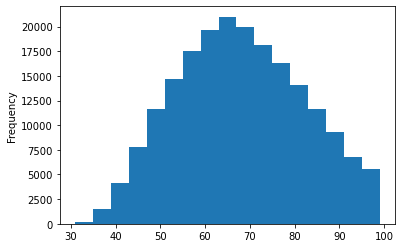

In [12]:
df['length'].plot(bins=17, kind='hist') 

In [13]:
df['length'].describebe()

count    200000.000000
mean         67.470575
std          14.161996
min          31.000000
25%          57.000000
50%          67.000000
75%          78.000000
max          99.000000
Name: length, dtype: float64

Lest grap the sentence that has higher character

In [18]:
df[df['length']==99.00]['text'].iloc[0:5]

301     Why is 17 called the mother-in-law in black ja...
345     Imagine a masonry wall... now, picture just on...
525     Welcome to drugs club, todd. i can't believe s...
823     If someone on the windows team at microsoft ge...
1001    Ice bowl photos still look cold after packers ...
Name: text, dtype: object

In [19]:
df[df['length']==99.00]['text'].iloc[0]

'Why is 17 called the mother-in-law in black jack? because you wanna hit it, but sometimes you cant.'

This sentence is one from the sentences that have higher number of characters

array([<AxesSubplot: title={'center': 'False'}>,
       <AxesSubplot: title={'center': 'True'}>], dtype=object)

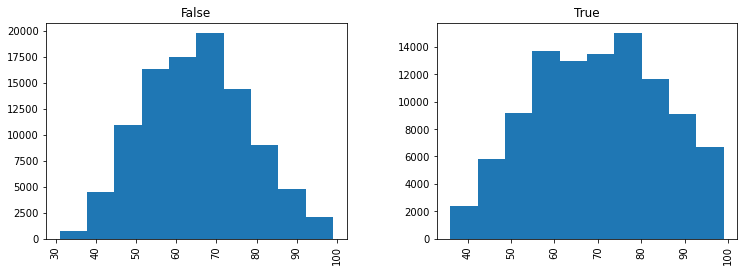

In [7]:
df.hist(column='length', by='humor', bins=10,figsize=(12,4))

#### Task


**Text preprocessing:** As a pre-processing step, perform both `stemming` and `lemmatizing` to normalize your text before classifying. For each technique use both the `CountVectorize`r and `TfidifVectorizer` and use options for stop words and max features to prepare the text data for your estimator.

**Classification:** Once you have prepared the text data with stemming lemmatizing techniques, consider `LogisticRegression`, `DecisionTreeClassifier`, and `MultinomialNB` as classification algorithms for the data. Compare their performance in terms of accuracy and speed.

Share the results of your best classifier in the form of a table with the best version of each estimator, a dictionary of the best parameters and the best score.

## Text Pre-processing

In [6]:
ps=PorterStemmer()
wnl=WordNetLemmatizer()

In [7]:
def text_process_lemmatizer(mess):
    """
    Takes in a string of text, then performs the following:
    1. Tokenization
    2. Remove all punctuation
    3.apply lower case
    4.split
    5. Remove all stopwords
    6.apply lemmatizing
    7.apply ''.join(doc)
    8. Returns a list of the cleaned text
    """
    sentences=sent_tokenize(mess)
    review=[nopunc for nopunc in sentences if nopunc not in string.punctuation]
    review=[lower.lower() for lower in review]
    review==[char.split() for char in review]
    review=[word for word in review if word not in stopwords.words('english')]
    review=[wnl.lemmatize(word) for word in review]
    review=''.join(review)
    return review

def text_process_stemmer(mess):
    """
    Takes in a string of text, then performs the following:
    1. Tokenization
    2. Remove all punctuation
    3.apply lower case
    4.split
    5. Remove all stopwords
    6.apply stemming
    7.apply ''.join(doc)
    8. Returns a list of the cleaned text
    """
    sentences=sent_tokenize(mess)
    review=[nopunc for nopunc in sentences if nopunc not in string.punctuation]
    review=[lower.lower() for lower in review]
    review==[char.split() for char in review]
    review=[word for word in review if word not in stopwords.words('english')]
    review=[ps.stem(word) for word in review]
    review=''.join(review)
    return review

In [8]:
df=df.drop('length',axis=1)
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [9]:
df['text'].head()

0    Joe biden rules out 2020 bid: 'guys, i'm not r...
1    Watch: darvish gave hitter whiplash with slow ...
2    What do you call a turtle without its shell? d...
3        5 reasons the 2016 election feels so personal
4    Pasco police shot mexican migrant from behind,...
Name: text, dtype: object

In [10]:
df['text'].head().apply(text_process_lemmatizer)

0    joe biden rules out 2020 bid: 'guys, i'm not r...
1    watch: darvish gave hitter whiplash with slow ...
2    what do you call a turtle without its shell?dead.
3        5 reasons the 2016 election feels so personal
4    pasco police shot mexican migrant from behind,...
Name: text, dtype: object

## Vectorization
now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

### Prepare the data

In [11]:
X=df['text']
y=df['humor']

In [16]:
X.shape

(200000,)

In [17]:
y.shape

(200000,)

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(len(X_train), len(X_test), len(y_train),len(y_test))

140000 60000 140000 60000


## Creating a Data Pipeline

In [13]:
#Pipeline applying lemmatization
pipeline_lemma_bow = Pipeline([
    ('Bow', CountVectorizer(analyzer=text_process_lemmatizer)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())])  # train on TF-IDF vectors w/ Naive Bayes classifier

pipeline_lemma_tfidfvec = Pipeline([
    ('tfidf',TfidfVectorizer(analyzer=text_process_lemmatizer)),  
    ('classifier', MultinomialNB())]) 


In [20]:
pipeline_lemma_bow.fit(X_train,y_train)
pre_lemma_bow = pipeline_lemma_bow.predict(X_test)
print(classification_report(pre_lemma_bow,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29541
        True       0.89      0.88      0.88     30459

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [21]:
pipeline_lemma_tfidfvec.fit(X_train,y_train)
pre_lemma_tfidfvec = pipeline_lemma_tfidfvec.predict(X_test)
print(classification_report(pre_lemma_tfidfvec,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29541
        True       0.89      0.88      0.88     30459

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [22]:
#Pipeline applying stemming
pipeline_stem_bow = Pipeline([
    ('Bow', CountVectorizer(analyzer=text_process_stemmer)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())])  # train on TF-IDF vectors w/ Naive Bayes classifier

pipeline_stem_tfidfvec = Pipeline([
    ('tfidf',TfidfVectorizer(analyzer=text_process_stemmer)),  
    ('classifier', MultinomialNB())]) 

In [23]:
pipeline_stem_bow.fit(X_train,y_train)
pre_stem_bow= pipeline_stem_bow.predict(X_test)
print(classification_report(pre_stem_bow,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29469
        True       0.89      0.87      0.88     30531

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [24]:
pipeline_stem_tfidfvec.fit(X_train,y_train)
pre_stem_tfidfvec= pipeline_stem_tfidfvec.predict(X_test)
print(classification_report(pre_stem_tfidfvec,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29469
        True       0.89      0.87      0.88     30531

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



### Create a GridSearch

In [14]:
params_lemma = {'tfidf__max_features': [100, 500, 1000]}
params_bow= {'Bow__max_features': [100, 500, 1000]}

### TF-IDF technique

Logestic Regression,Decision Tree, and Naive Bayes

In [20]:
#Naive Bayes gridsearch
naive_lemma_tfidf_grid=GridSearchCV(estimator=pipeline_lemma_tfidfvec,param_grid=params_lemma, cv=5)

#Logestic Regression pipeline and gridsearch
pipe_lemma_tfidfvec_lgr = Pipeline([
    ('tfidf',TfidfVectorizer(analyzer=text_process_lemmatizer)),  
    ('classifier', LogisticRegression(max_iter=10000))]) 
lgr_lemma_tfidf_grid=GridSearchCV(estimator=pipe_lemma_tfidfvec_lgr,param_grid=params_lemma, cv=5)

#Decision tree pipeline and gridsearch
pipe_lemma_tfidfvec_dtree = Pipeline([  
    ('tfidf',TfidfVectorizer(analyzer=text_process_lemmatizer)),  
    ('classifier', DecisionTreeClassifier())]) 
dtree_lemma_tfidf_grid=GridSearchCV(estimator=pipe_lemma_tfidfvec_dtree,param_grid=params_lemma,cv=5)


In [16]:
#naive bayes classifier
import time
start_time=time.time()
naive_lemma_tfidf_grid.fit(X_train,y_train)
end_time=time.time()
total_NB_time=(end_time-start_time)
pre_lemma_tfidfvec_NB = naive_lemma_tfidf_grid.predict(X_test)
print(classification_report(pre_lemma_tfidfvec_NB,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29541
        True       0.89      0.88      0.88     30459

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [17]:
naive_lemma_tfidf_grid.best_params_

{'tfidf__max_features': 500}

In [18]:
naive_lemma_tfidf_grid.best_score_

0.8784714285714286

In [23]:
total_NB_time

515.8764867782593

In [21]:
#Logestic Regression classifier
import time
start_time=time.time()
lgr_lemma_tfidf_grid.fit(X_train,y_train)
end_time=time.time()
total_lgr_time=(end_time-start_time)
pre_lemma_tfidfvec_lgr = lgr_lemma_tfidf_grid.predict(X_test)
print(classification_report(pre_lemma_tfidfvec_lgr,y_test))

              precision    recall  f1-score   support

       False       0.91      0.89      0.90     30391
        True       0.89      0.91      0.90     29609

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000



In [24]:
lgr_lemma_tfidf_grid.best_params_

{'tfidf__max_features': 500}

In [26]:
lgr_lemma_tfidf_grid.best_score_

0.8974714285714285

In [27]:
total_lgr_time

522.5550501346588

In [28]:
#Decision Tree classifier
import time
start_time=time.time()
dtree_lemma_tfidf_grid.fit(X_train,y_train)
end_time=time.time()
total_dtree_time=(end_time-start_time)
pre_lemma_tfidfvec_dtree = dtree_lemma_tfidf_grid.predict(X_test)
print(classification_report(pre_lemma_tfidfvec_dtree,y_test))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     29992
         1.0       0.88      0.88      0.88     30008

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [29]:
dtree_lemma_tfidf_grid.best_params_

{'tfidf__max_features': 500}

In [30]:
dtree_lemma_tfidf_grid.best_score_

0.8794428571428572

In [31]:
total_dtree_time

845.7613286972046

### Bag of words

Logestic Regression,Decision Tree, and Naive Bayes

In [32]:
#Naive Bayes gridsearch
naive_lemma_bow_grid=GridSearchCV(estimator=pipeline_lemma_bow,param_grid=params_bow, cv=5)

#Logestic Regression pipeline and gridsearch
pipe_lemma_bow_lgr = Pipeline([
    ('Bow',CountVectorizer(analyzer=text_process_lemmatizer)),  
    ('classifier', LogisticRegression(max_iter=10000))]) 
lgr_lemma_bow_grid=GridSearchCV(estimator=pipe_lemma_bow_lgr,param_grid=params_bow, cv=5)

#Decision tree pipeline and gridsearch
pipe_lemma_bow_dtree = Pipeline([  
    ('Bow',CountVectorizer(analyzer=text_process_lemmatizer)),  
    ('classifier', DecisionTreeClassifier())]) 
dtree_lemma_bow_grid=GridSearchCV(estimator=pipe_lemma_bow_dtree,param_grid=params_bow,cv=5)



In [33]:
#naive bayes classifier with Bag of words
import time
start_time=time.time()
naive_lemma_bow_grid.fit(X_train,y_train)
end_time=time.time()
total_NBBow_time=(end_time-start_time)
pre_lemma_bow_NB = naive_lemma_bow_grid.predict(X_test)
print(classification_report(pre_lemma_bow_NB,y_test))

              precision    recall  f1-score   support

       False       0.87      0.88      0.88     29541
        True       0.89      0.88      0.88     30459

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [34]:
naive_lemma_bow_grid.best_params_

{'Bow__max_features': 500}

In [35]:
naive_lemma_bow_grid.best_score_

0.8784714285714286

In [36]:
total_NBBow_time

500.7433571815491

In [37]:
#Logestic Regression classifier with Bag of words
import time
start_time=time.time()
lgr_lemma_bow_grid.fit(X_train,y_train)
end_time=time.time()
total_lgrbow_time=(end_time-start_time)
pre_lemma_bow_lgr = lgr_lemma_bow_grid.predict(X_test)
print(classification_report(pre_lemma_bow_lgr,y_test))

              precision    recall  f1-score   support

       False       0.91      0.90      0.90     30381
        True       0.90      0.91      0.90     29619

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000



In [38]:
lgr_lemma_bow_grid.best_params_

{'Bow__max_features': 100}

In [39]:
lgr_lemma_bow_grid.best_score_

0.9030714285714285

In [40]:
 total_lgrbow_time

661.0666699409485

In [41]:
#Logestic Regression classifier with Bag of words
import time
start_time=time.time()
dtree_lemma_bow_grid.fit(X_train,y_train)
end_time=time.time()
total_dtreebow_time=(end_time-start_time)
pre_lemma_bow_dtree = dtree_lemma_bow_grid.predict(X_test)
print(classification_report(pre_lemma_bow_dtree,y_test))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     29756
         1.0       0.88      0.88      0.88     30244

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [42]:
dtree_lemma_bow_grid.best_params_

{'Bow__max_features': 500}

In [43]:
dtree_lemma_bow_grid.best_score_

0.8780857142857144

In [44]:
total_dtreebow_time

679.3035266399384

In [45]:
pd.DataFrame({'model': ['Logistic_TfidefVectorizer', 'Decision Tree_TfidfVectorizer', 'Bayes_TfidfVectorizer',
                        'Logistic_CountVectorizer', 'Decision Tree_CountVectorizer', 'Bayes_CountVectorizer'], 
             'best_score': ['0.8974714285714285', '0.8794428571428572', '0.8784714285714286','0.9030714285714285', '0.8780857142857144', '0.8784714285714286'],
             'Train Time': ['522.5550501346588', '845.7613286972046', '515.8764867782593 sec','661.0666699409485', '679.3035266399384', '500.7433571815491'],
             'best_params':[500,500,500,100,500,500]}).set_index('model')

,best_score,Train Time,best_params
model,,,
Logistic_TfidefVectorizer,0.8974714285714285,522.5550501346588,500
Decision Tree_TfidfVectorizer,0.8794428571428572,845.7613286972046,500
Bayes_TfidfVectorizer,0.8784714285714286,515.8764867782593 sec,500
Logistic_CountVectorizer,0.9030714285714285,661.0666699409485,100
Decision Tree_CountVectorizer,0.8780857142857144,679.3035266399384,500
Bayes_CountVectorizer,0.8784714285714286,500.7433571815491,500
